In [1]:
import os
import tempfile

#numpy
import numpy as np
# pandas
from pandas import read_csv
# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
#teras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Accuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [53]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_metrics(history):
    metrics =  ['loss', 'AUC', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          class_names = None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    if class_names is None:
        x_labels = y_labels = classes
    else:
        x_labels = y_labels = class_names
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=x_labels, yticklabels=y_labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [91]:
METRICS = [
    AUC(name = 'AUC'),
    Accuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall')    
]


def make_model(metrics = METRICS, output_bias = None):   
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)    
    #Initialising NN
    model = Sequential()

    #First layer
    model.add(Dense(8, activation='relu', input_shape=(13,)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #Second layer
    model.add(Dense(12, activation='relu'))
   # model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr= 0.001),
                  metrics=metrics
                 )
    return model

###

In [2]:
seed = 11
np.random.seed(seed)


In [3]:
# load dataset
dataset = input('\nWhich is the name of the dataset? ')
dataframe = read_csv(dataset, header=0)
dataset = dataframe.values
#dataset = np.random.shuffle(dataset)
first_col = input("\nSelect first column: \n") #2
last_col = input('\nSelect last col: \n')          #15

X = dataset[:,int(first_col):int(last_col)].astype(float)   # columns from 3rd to 14th into X
Y = dataset[:,int(last_col)] #label column (15th) into Y 


Which is the name of the dataset? analysis.csv

Select first column: 
2

Select last col: 
15


In [4]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

#One-hot encoding
transformed_Y = to_categorical(encoded_Y)

In [5]:
bkg, sgn = np.bincount(encoded_Y)

total =  bkg + sgn
print('Samples:\n Total: {}\n Background: {} \n Signal: {} \n Signal samples are {:.2f}% of the total'.format(total, bkg, sgn, 100*sgn/total))

Samples:
 Total: 3800033
 Background: 3713773 
 Signal: 86260 
 Signal samples are 2.27% of the total


In [ ]:
weight_for_0 = (1 / bkg)*(total)/2.0
weight_for_1 = (1 / sgn)*(total)/2.0


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    transformed_Y,
                                                    test_size=0.25,
                                                    random_state=seed,
                                                    shuffle = True)

scaler = StandardScaler()
X_train =scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [7]:
print('Training labels shape:', Y_train.shape)
print('Validation labels shape:', Y_test.shape)


print('Training features shape:', X_train.shape)
print('Validation features shape:', X_test.shape)

Training labels shape: (2850024, 2)
Validation labels shape: (950009, 2)
Training features shape: (2850024, 13)
Validation features shape: (950009, 13)


In [92]:
EPOCHS = 100
BATCH_SIZE = 150000
val_data = (X_test,Y_test)
#checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_precision', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 1,
    patience = 200,
    mode = 'min',
    restore_best_weights = True)



In [74]:
model = make_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 8)                 112       
_________________________________________________________________
dropout_18 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 12)                108       
_________________________________________________________________
dropout_19 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 26        
Total params: 246
Trainable params: 246
Non-trainable params: 0
_________________________________________________________________


In [25]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [93]:
model = make_model()
model.load_weights(initial_weights)

In [94]:
%%time
history=model.fit(X_train,
                  Y_train,
                  epochs = EPOCHS,
                  shuffle = True,
                  validation_data=val_data,
                  #validation_freq=5,
                  callbacks = [early_stopping],
                  batch_size = BATCH_SIZE,
                  class_weight=class_weight
                 )

Train on 2850024 samples, validate on 950009 samples
Epoch 1/100
2850024/2850024 [==============================] - 10s 3us/sample - loss: 0.5887 - AUC: 0.7112 - accuracy: 0.0015 - precision: 0.6739 - recall: 0.6115 - val_loss: 0.5311 - val_AUC: 0.7695 - val_accuracy: 1.5789e-06 - val_precision: 0.6702 - val_recall: 0.6648
Epoch 2/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5879 - AUC: 0.7105 - accuracy: 0.0015 - precision: 0.6731 - recall: 0.6109 - val_loss: 0.5307 - val_AUC: 0.7702 - val_accuracy: 2.6316e-06 - val_precision: 0.6711 - val_recall: 0.6656
Epoch 3/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5883 - AUC: 0.7107 - accuracy: 0.0015 - precision: 0.6733 - recall: 0.6113 - val_loss: 0.5309 - val_AUC: 0.7697 - val_accuracy: 1.5789e-06 - val_precision: 0.6702 - val_recall: 0.6646
Epoch 4/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5882 - AUC: 0.7071 - accuracy: 0.0015 - precis

Epoch 31/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5870 - AUC: 0.7100 - accuracy: 0.0015 - precision: 0.6724 - recall: 0.6158 - val_loss: 0.5304 - val_AUC: 0.7687 - val_accuracy: 1.0526e-06 - val_precision: 0.6656 - val_recall: 0.6606
Epoch 32/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5862 - AUC: 0.7108 - accuracy: 0.0015 - precision: 0.6733 - recall: 0.6165 - val_loss: 0.5299 - val_AUC: 0.7700 - val_accuracy: 1.5789e-06 - val_precision: 0.6671 - val_recall: 0.6620
Epoch 33/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5865 - AUC: 0.7115 - accuracy: 0.0015 - precision: 0.6736 - recall: 0.6169 - val_loss: 0.5293 - val_AUC: 0.7714 - val_accuracy: 0.0000e+00 - val_precision: 0.6685 - val_recall: 0.6635
Epoch 34/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5880 - AUC: 0.7129 - accuracy: 0.0015 - precision: 0.6752 - recall: 0.6186 - val_loss: 0.5288 - 

2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5846 - AUC: 0.7182 - accuracy: 0.0016 - precision: 0.6791 - recall: 0.6246 - val_loss: 0.5271 - val_AUC: 0.7763 - val_accuracy: 5.2631e-07 - val_precision: 0.6732 - val_recall: 0.6692
Epoch 62/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5862 - AUC: 0.7180 - accuracy: 0.0015 - precision: 0.6791 - recall: 0.6245 - val_loss: 0.5269 - val_AUC: 0.7765 - val_accuracy: 5.2631e-07 - val_precision: 0.6733 - val_recall: 0.6693
Epoch 63/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5860 - AUC: 0.7182 - accuracy: 0.0016 - precision: 0.6790 - recall: 0.6247 - val_loss: 0.5265 - val_AUC: 0.7772 - val_accuracy: 2.1052e-06 - val_precision: 0.6741 - val_recall: 0.6702
Epoch 64/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5855 - AUC: 0.7197 - accuracy: 0.0016 - precision: 0.6800 - recall: 0.6254 - val_loss: 0.5261 - val_AUC: 0.77

2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5838 - AUC: 0.7218 - accuracy: 0.0016 - precision: 0.6828 - recall: 0.6363 - val_loss: 0.5257 - val_AUC: 0.7787 - val_accuracy: 1.0526e-06 - val_precision: 0.6733 - val_recall: 0.6701
Epoch 92/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5836 - AUC: 0.7227 - accuracy: 0.0016 - precision: 0.6836 - recall: 0.6369 - val_loss: 0.5254 - val_AUC: 0.7795 - val_accuracy: 2.1052e-06 - val_precision: 0.6742 - val_recall: 0.6710
Epoch 93/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5847 - AUC: 0.7237 - accuracy: 0.0016 - precision: 0.6844 - recall: 0.6377 - val_loss: 0.5249 - val_AUC: 0.7806 - val_accuracy: 1.0526e-06 - val_precision: 0.6754 - val_recall: 0.6721
Epoch 94/100
2850024/2850024 [==============================] - 9s 3us/sample - loss: 0.5854 - AUC: 0.7234 - accuracy: 0.0016 - precision: 0.6841 - recall: 0.6371 - val_loss: 0.5254 - val_AUC: 0.77

In [90]:
model.save_weights(initial_weights)

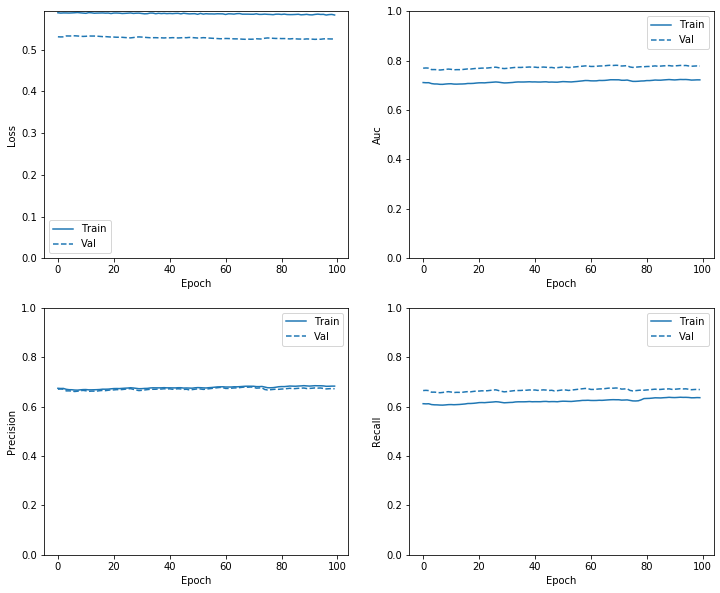

In [95]:
plot_metrics(history)

In [84]:
#compute predictions
predictions = model.predict(X_test)
print(predictions)
y_pred = np.array([np.argmax(probas) for probas in predictions])
y_test = np.array([np.argmax(label) for label in Y_test])

classes = unique_labels(y_test, y_pred)
class_names = unique_labels(Y)

#not-fancy confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = classes)
print(cm)

[[0.9871305  0.01383755]
 [0.450267   0.54815155]
 [0.9366248  0.06658602]
 ...
 [0.51886904 0.47920728]
 [0.38105184 0.6276778 ]
 [0.75969386 0.24204548]]


Confusion matrix, without normalization
[[622757 305883]
 [  5211  16158]]


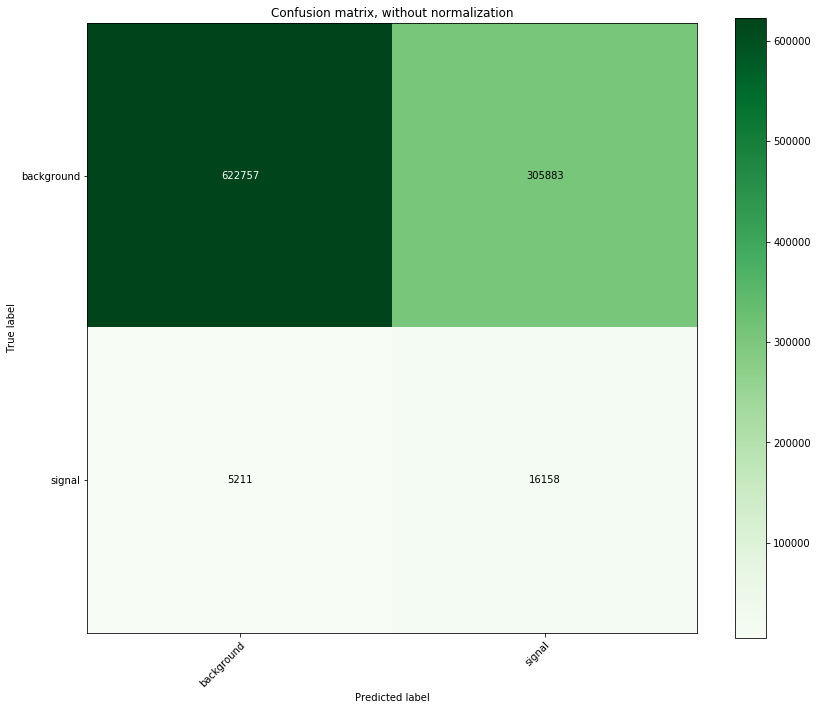

In [86]:
plot_confusion_matrix(y_test, y_pred, classes, class_names)